In [1]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
### Load data
files = glob.glob("../data/onetrack_multicluster/pion_files/*.npy")
# train = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[:350])])
# val = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[350:400])])
# test = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[400:])])
test = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[:2])])
# print("Training dataframe has {:,} events.".format(train.shape[0]))
# print("Validation dataframe has {:,} events.".format(val.shape[0]))
print("Testing dataframe has {:,} events.".format(test.shape[0]))

100%|██████████| 2/2 [00:02<00:00,  1.23s/it]

Testing dataframe has 20,550 events.


In [17]:
def process(df): 
    ### Start the dataframe of inputs 
    ncols = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list())).shape[1]
    df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(ncols)]))

    ### Add track pT & truth particle E 
    track_pt = np.array(df.trackPt.explode())
    truth_particle_e = np.array(df.truthPartE.explode())
    track_eta = np.array(df.trackEta.explode())
    track_phi = np.array(df.trackPhi.explode())
    track_z0 = np.array(df.trackZ0.explode())

    df2["track_pt"] = track_pt
    df2["track_eta"] = track_eta
    df2["track_phi"] = track_phi
    df2["track_z0"] = track_z0
    df2["truth_particle_e"] = truth_particle_e

    ### Drop infs/NaNs 
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df2 = df2.fillna(0)

    ### Cluster_E > 0.5
    df2 = df2[df2.cluster_e_0 > 0.5]

    ### Lose outliers in track pT 
    df2 = df2[df2.track_pt < 5000]

    ### Cast as float
    df2 = df2.astype('float32')

    ### Add the log of all energy variables
    for var in df2.keys():
        if var in ["track_eta", "track_phi", "track_z0"]:
            continue
        else:
            df2['log10_'+var] = np.log10(df2[var])

    ### Do this again? 
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df2 = df2.fillna(0)
    return df2

In [18]:
df_train = process(train)
# df_val = process(val)
# df_test = process(test)

In [19]:
df_train.to_hdf("train_dnn.h5", "df")
# df_val.to_hdf("val_dnn.h5", "df")
# df_test.to_hdf("test_dnn.h5", "df")

In [23]:
# train_vars = [
#     'log10_cluster_e_0', 
#     'log10_cluster_e_1', 
#     'log10_cluster_e_2', 
#     'log10_cluster_e_3', 
#     'log10_cluster_e_4', 
#     'log10_cluster_e_5', 
#     'log10_cluster_e_6', 
#     'log10_cluster_e_7', 
#     'log10_cluster_e_8', 
#     'log10_cluster_e_9', 
#     'log10_track_pt',
#     'track_eta',
#     'track_phi',
#     'track_z0'
#              ]

### All clusters + track pt/eta/phi/z0
train_vars = [var for var in df_train.keys() if var.startswith('log10') and var != 'log10_truth_particle_e']
train_vars += ['track_eta', 'track_phi', 'track_z0']

### Augment df_test with any extra columns
df_test[[var for var in df_train.keys() if var not in df_test.keys()]] = 0 

train_x = df_train[train_vars].values
train_y = df_train['log10_truth_particle_e'].values
val_x = df_val[train_vars].values
val_y = df_val['log10_truth_particle_e'].values
test_x = df_test[train_vars].values
test_y = df_test['log10_truth_particle_e'].values

In [27]:
### Normalize the inputs 
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
val_x = sc.transform(val_x)
test_x = sc.transform(test_x)

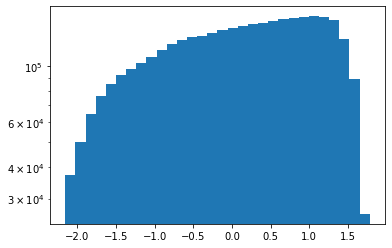

In [28]:
plt.hist(train_x[:,0], bins=30);
plt.yscale('log');

In [29]:
def regression_model():
    model = Sequential()
    model.add(Dense(50, input_dim=train_x.shape[1], activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [30]:
model = regression_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2000      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 7,151
Trainable params: 7,151
Non-trainable params: 0
_________________________________________________________________


2022-06-22 15:50:19.400038: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 15:50:21.003980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38577 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-06-22 15:50:21.004799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 42494 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2022-06-22 15:50:21.005469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:G

In [58]:
%%time
history = model.fit(
    train_x,
    train_y,
    validation_data=(val_x, val_y),
#     validation_split=0.2,
    batch_size=32,
    verbose=1, epochs=10)

Epoch 1/10
109682/109682 [==============================] - 228s 2ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 2/10
109682/109682 [==============================] - 229s 2ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 3/10
109682/109682 [==============================] - 230s 2ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 4/10
109682/109682 [==============================] - 230s 2ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/10
109682/109682 [==============================] - 229s 2ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 6/10
109682/109682 [==============================] - 229s 2ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 7/10
109682/109682 [==============================] - 229s 2ms/step - loss: 0.0023 - val_loss: 0.0048
Epoch 8/10
109682/109682 [==============================] - 230s 2ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 9/10
109682/109682 [==============================] - 230s 2ms/step - loss: 0.0022 - val_loss: 0.0047
Epoch 10/10
109682/109682 [=

# Load test set

In [55]:
### Load data
files = glob.glob("../data/onetrack_multicluster/pion_files/*.npy")
test = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[400:415])])
print("Testing dataframe has {:,} events.".format(test.shape[0]))

100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


Testing dataframe has 154,610 events.


In [67]:
df_test = process(test)

/clusterfs/ml4hep/mpettee/miniconda3/envs/nbdev/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [68]:
len(df_test)

146414

In [58]:
pred_file = 'results/onetrack_multicluster/piyush_june22/gnn_allclusters_cells/inference_predictions.npz'
predictions = np.load(pred_file)
targets_regress = predictions['targets']
outputs_regress = predictions['outputs'][:,0]
df = pd.DataFrame(np.vstack([targets_regress, outputs_regress]).T, columns=['targets_regress', 'outputs_regress'])

In [59]:
len(df)

1000777

In [69]:
transformer = np.load('pub_note_results/Attention_Prediction_TRK_Large_fixed.npz') # as of June 24
df_transformer = pd.DataFrame(np.vstack([transformer['target'],transformer['prediction']]).T, columns=["targets_regress", "outputs_regress"])

In [70]:
len(df_transformer)

136116

In [71]:
df.targets_regress.mean()

324.6898

In [72]:
df_test.truth_particle_e.mean()

341.2480616249696

In [73]:
df_transformer.targets_regress.mean()

210.32066

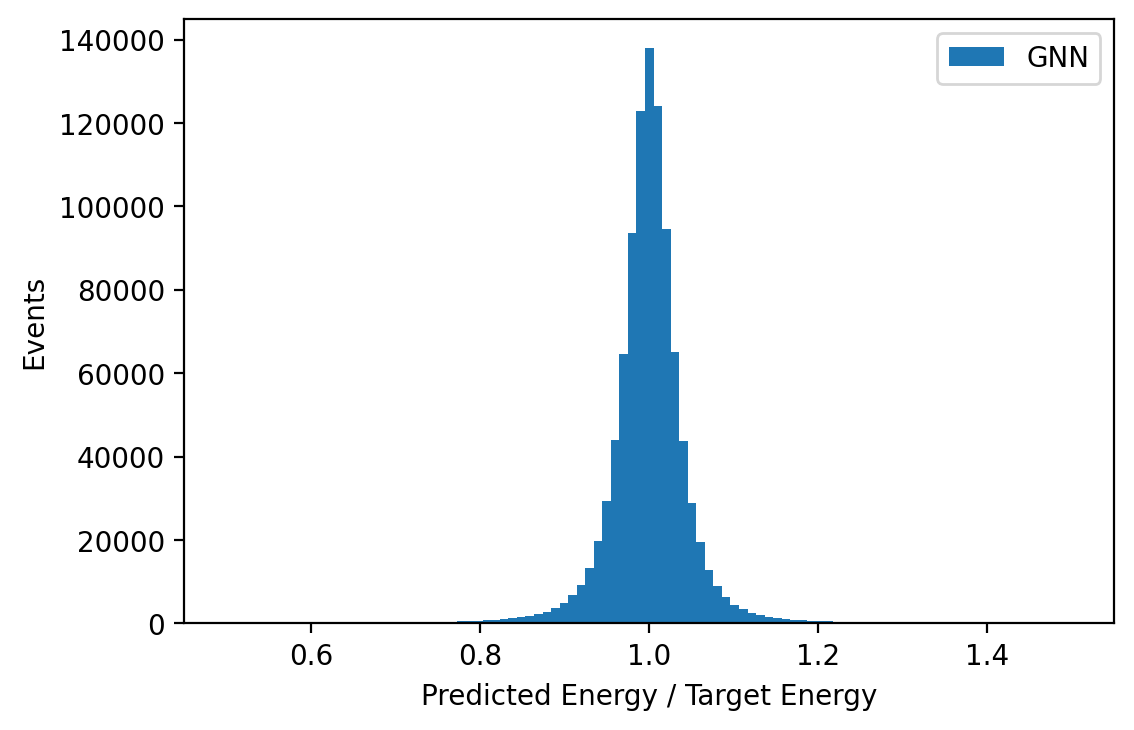

In [87]:
plt.figure(dpi=200)
plt.hist(df.outputs_regress/df.targets_regress, 
        bins=np.linspace(0.5,1.5,100),
         label="GNN",
        );
plt.legend();
plt.xlabel("Predicted Energy / Target Energy");
plt.ylabel("Events");

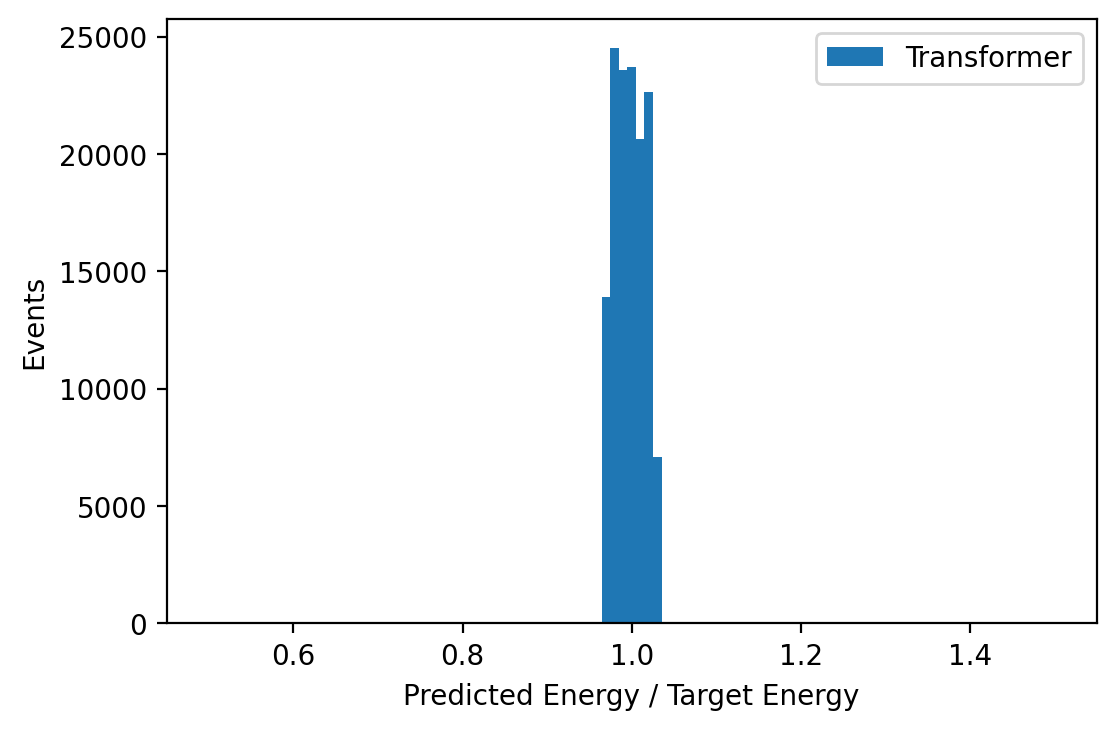

In [89]:
plt.figure(dpi=200)
plt.hist(df_transformer.outputs_regress/df_transformer.targets_regress, 
        bins=np.linspace(0.5,1.5,100),
         label="Transformer",
        );
plt.legend()
plt.xlabel("Predicted Energy / Target Energy");
plt.ylabel("Events");

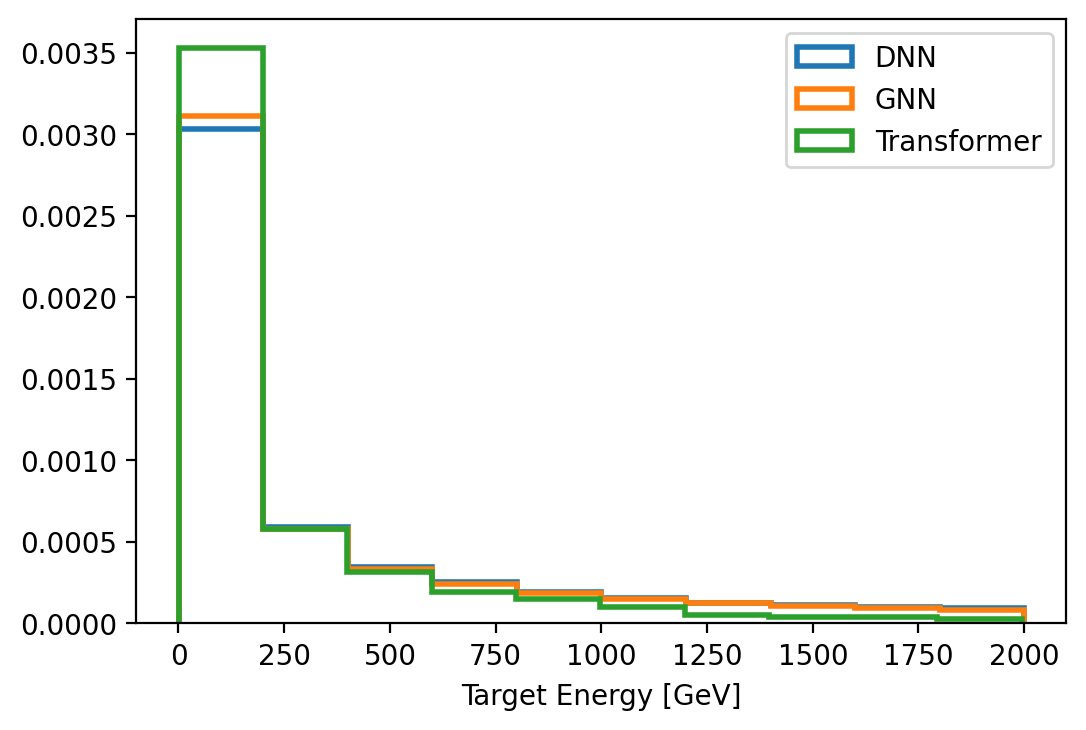

In [74]:
plt.figure(dpi=200)
plt.hist(df_test.truth_particle_e, label="DNN", histtype="step", alpha=1., density=True, linewidth=2);
plt.hist(df.targets_regress, label="GNN", histtype="step", alpha=1., density=True, linewidth=2);
plt.hist(df_transformer.targets_regress, label="Transformer", histtype="step", alpha=1., density=True, linewidth=2);
plt.legend();
plt.xlabel("Target Energy [GeV]");

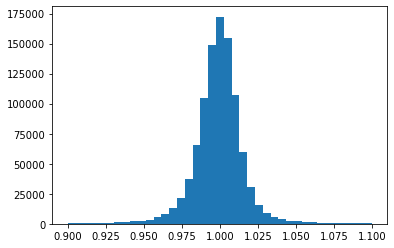

In [59]:
### Evaluate performance on test set 
df_test['nn_output'] = model.predict(test_x)
plt.hist(df_test.nn_output/df_test.log10_truth_particle_e, bins=np.linspace(0.9,1.1,40));

In [60]:
df_test.truth_particle_e.max()

1999.997314453125

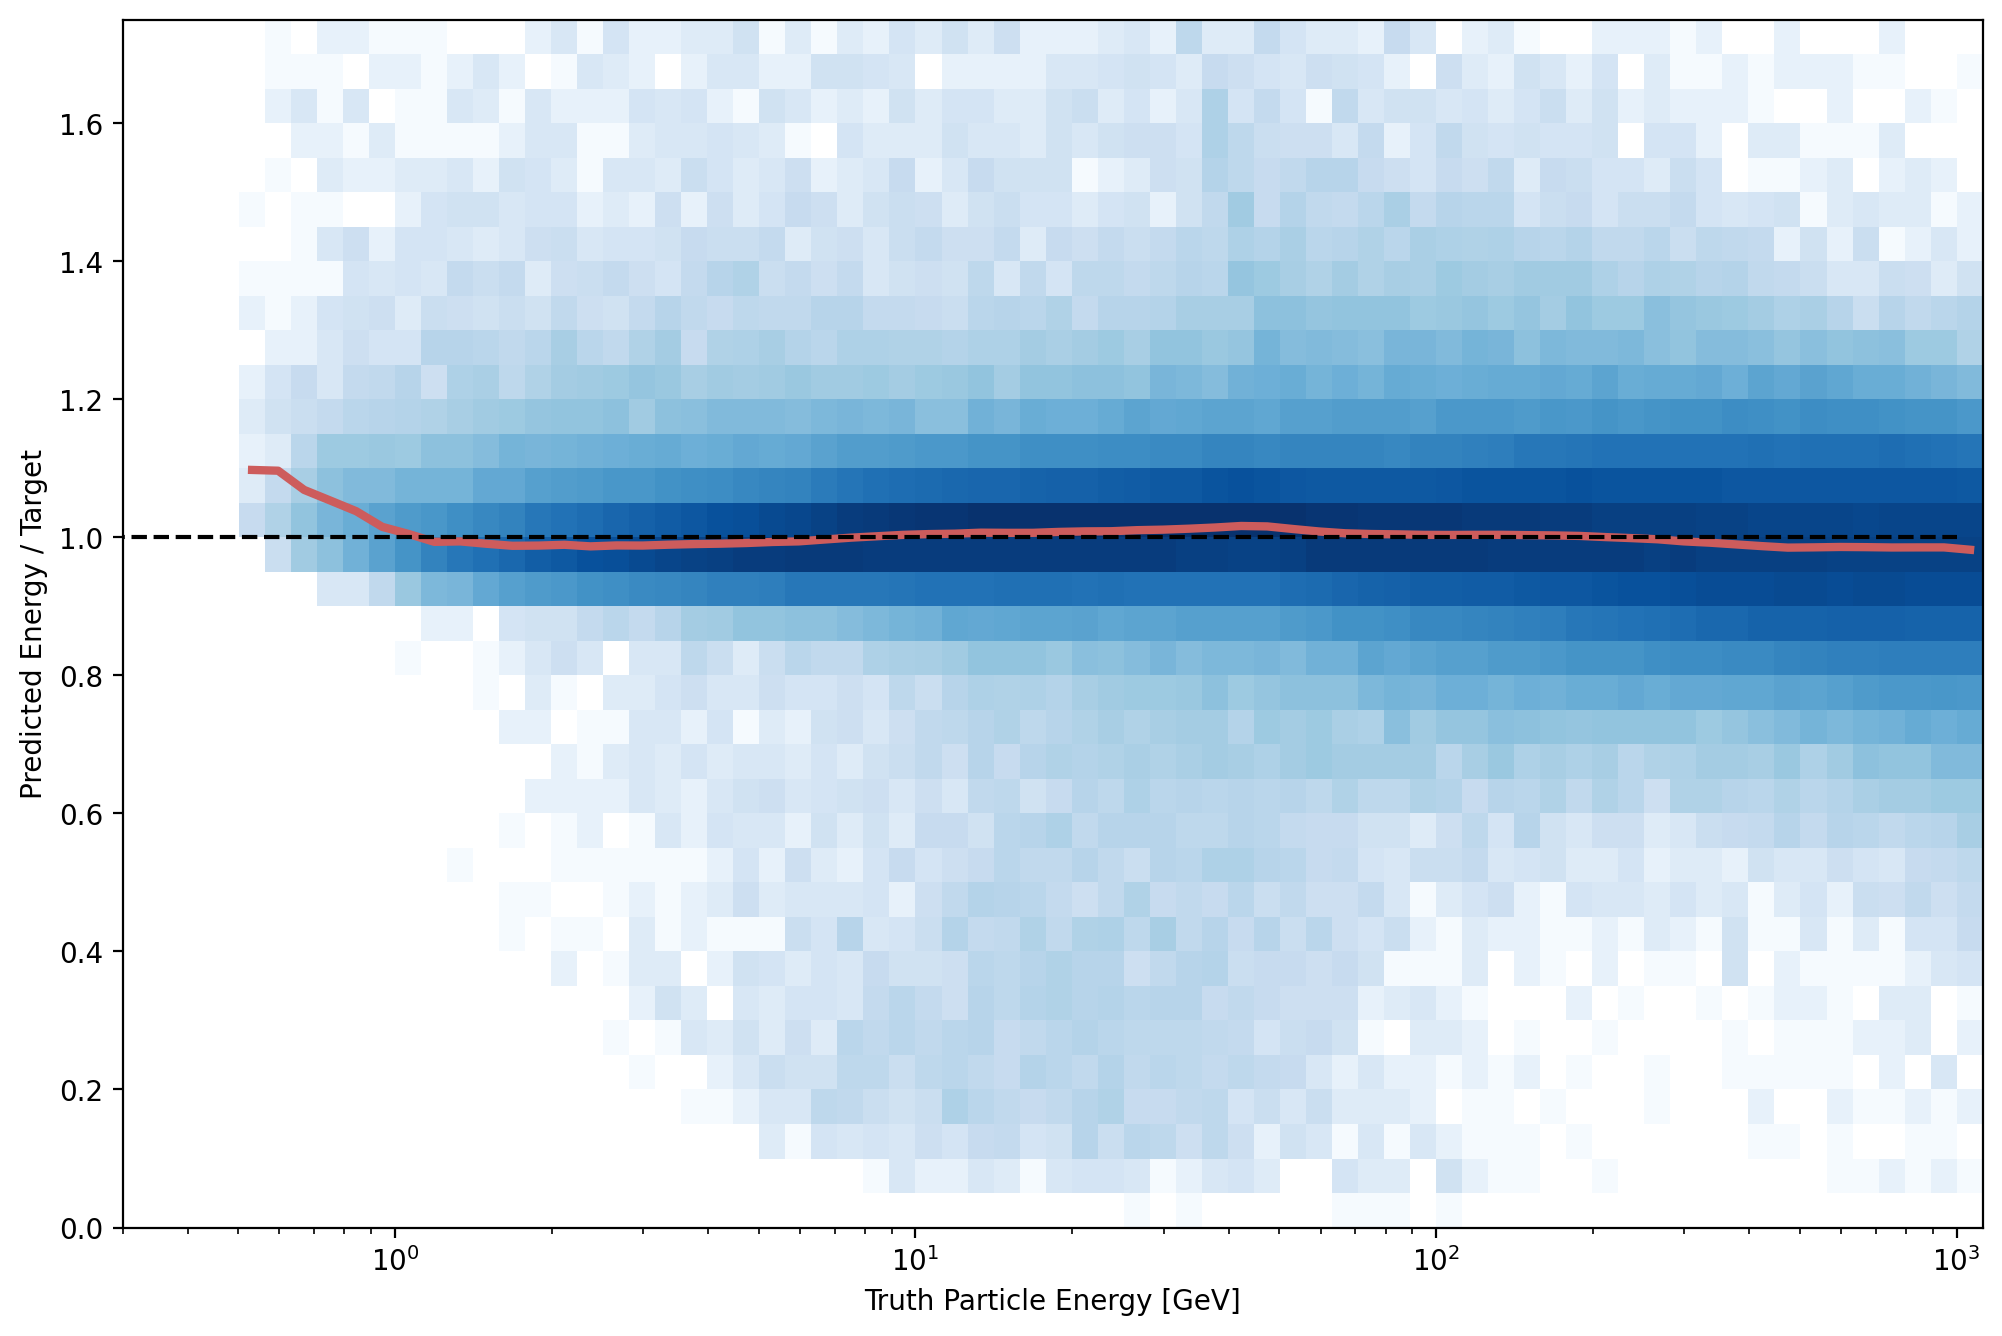

In [63]:
### Response median plot 
import scipy.stats as stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

x = df_test.truth_particle_e
y = (10**df_test.nn_output)/x

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.05)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
profileXMed = stats.binned_statistic(
    x, y, bins=xbin, statistic='median').statistic

c_map = ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())
fig = plt.figure(figsize=(12,8), dpi=200)
fig.patch.set_facecolor('white')
plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);
plt.plot(np.array(xcenter), np.array(profileXMed), color='indianred', linewidth=3)
plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black');
plt.xscale('log')
plt.ylim(0, 1.75)
plt.xlim(0.3, )
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Predicted Energy / Target');
# np.savez('pub_note_results/response_medians_dnn_2.npz', response_median=profileXMed, xcenter=xcenter)

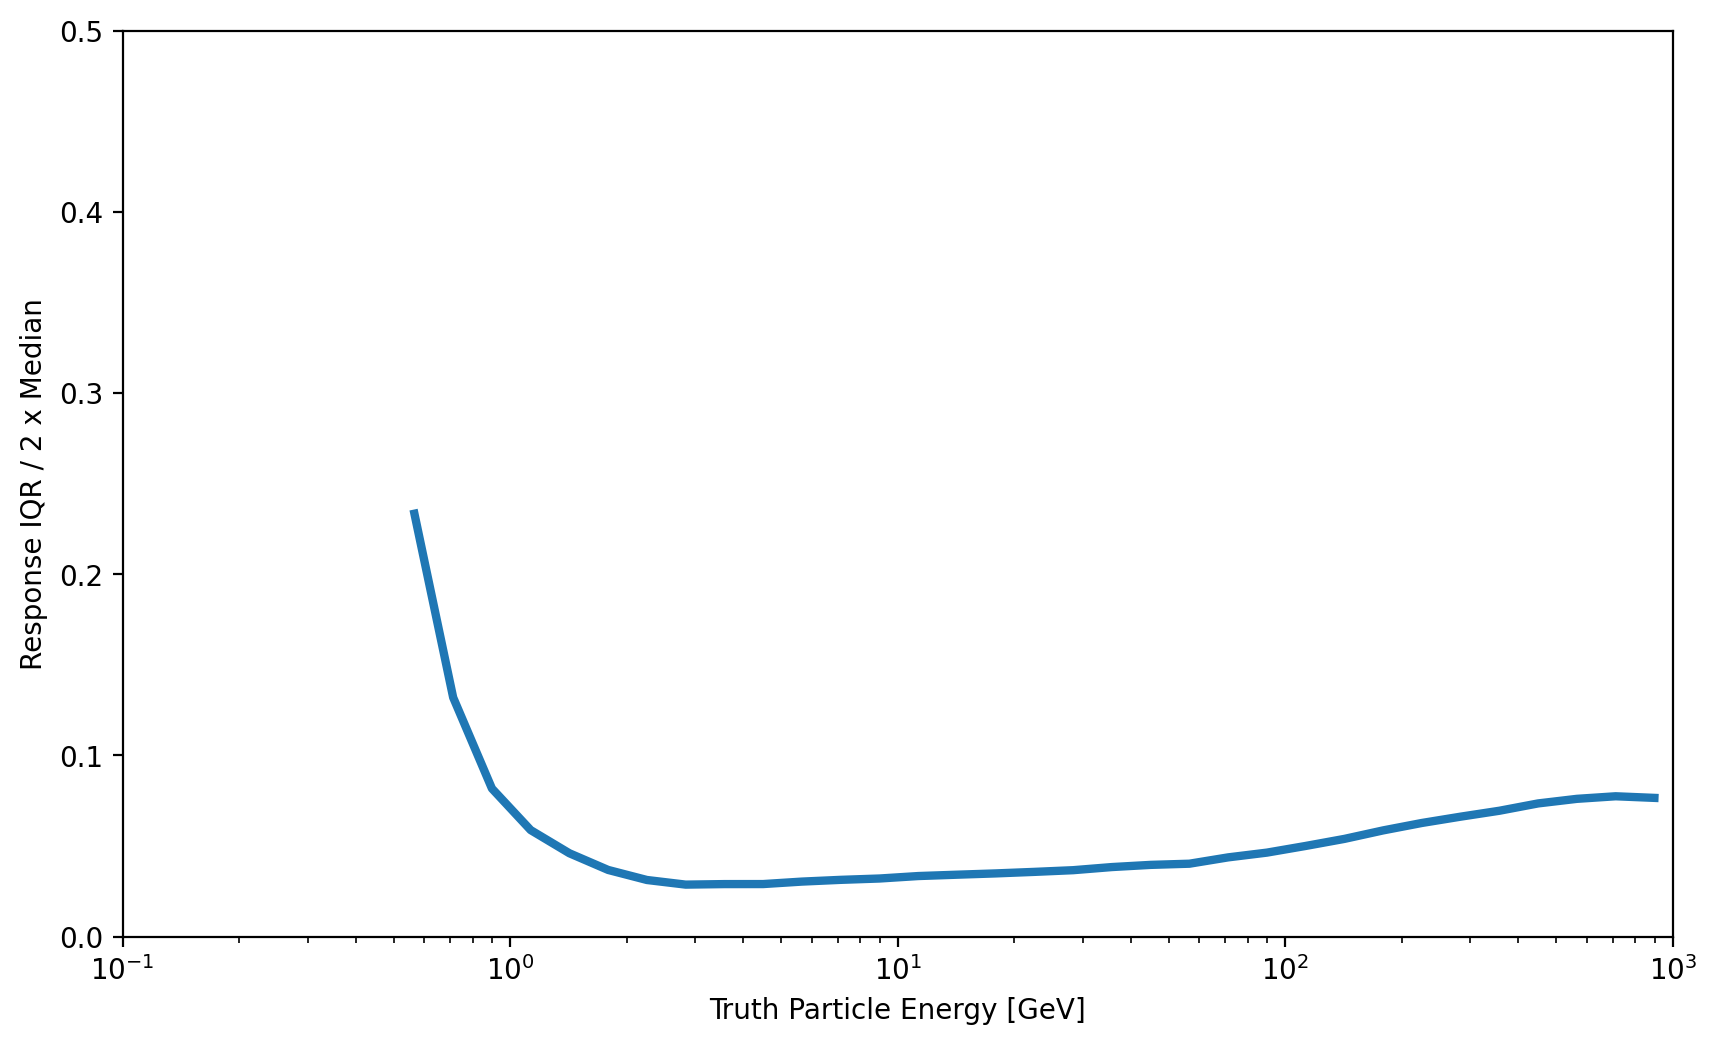

In [64]:
### IQR plot 

def iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q84, q16 = np.percentile(x, [84, 16])
    iqr = q84 - q16
    med = np.median(x)
    return iqr / (2*med)

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.1)]
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
resolution = stats.binned_statistic(x, y, bins=xbin, statistic=iqrOverMed).statistic

fig = plt.figure(figsize=(10,6), dpi=200)
fig.patch.set_facecolor('white')
plt.plot(xcenter, resolution, linewidth=3)
plt.xscale('log')
plt.xlim(0.1, 1000)
plt.ylim(0,0.5)
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Response IQR / 2 x Median');

# np.savez('pub_note_results/iqr_dnn_2.npz', iqr=resolution, xcenter=xcenter)

# Misc

In [7]:
train = pd.read_hdf("train_dnn.h5")
val = pd.read_hdf("val_dnn.h5")
test = pd.read_hdf("test_dnn.h5")

In [13]:
train.truth_particle_e.min()

0.38400813937187195

In [14]:
val.truth_particle_e.min()

0.4962927997112274

In [15]:
test.truth_particle_e.min()

0.5178743600845337

In [50]:
import uproot
from glob import glob
import json 
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pi0_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900246.PG_singlepi0_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pion_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900247.PG_singlepion_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pi0_files = sorted(glob(pi0_dir+"*.root"))
pion_files = sorted(glob(pion_dir+"*.root"))

variables = ["nTrack", "truthPartE"]

df_all = pd.concat([pd.DataFrame(uproot.open(file)["EventTree"].arrays(variables, library = "np")) 
                for file in tqdm(pion_files)])
df_all["truthPartE"] = df_all.truthPartE.astype('float')
df_all.reset_index(inplace=True)

100%|██████████| 500/500 [01:00<00:00,  8.24it/s]


In [51]:
df_all[(df_all.truthPartE < 0.201)].nTrack.value_counts()

0    5433
Name: nTrack, dtype: int64

In [52]:
df_all[df_all.nTrack == 1].truthPartE.min()

0.20454370975494385

In [ ]:
print(len(df_all[(df_all.truthPartE < 0.201) & (df_all.nTrack == 1)]))
print(df_all[(df_all.truthPartE < 0.201) & (df_all.nTrack == 1)].nTrac)

In [87]:
pi0_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900246.PG_singlepi0_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pion_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900247.PG_singlepion_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pi0_files = sorted(glob(pi0_dir+"*.root"))
pion_files = sorted(glob(pion_dir+"*.root"))

variables = ["nTrack", "truthPartE", "cluster_E"]

df = pd.concat([pd.DataFrame(uproot.open(file)["EventTree"].arrays(variables, library = "np")) 
                for file in tqdm(pion_files)])
df["truthPartE"] = df.truthPartE.astype('float')
df.reset_index(inplace=True)

print(df[(df.truthPartE < 0.201)].nTrack.value_counts())
print("Minimum truthPartE with nTrack == 1 is {:.5f}.".format(df[df.nTrack == 1].truthPartE.min()))


100%|██████████| 500/500 [01:11<00:00,  7.00it/s]


0    5433
Name: nTrack, dtype: int64
Minimum truthPartE with nTrack == 1 is 0.20454.


In [88]:
print(df[(df.truthPartE < 0.5)].nTrack.value_counts())

0    994309
1       199
Name: nTrack, dtype: int64


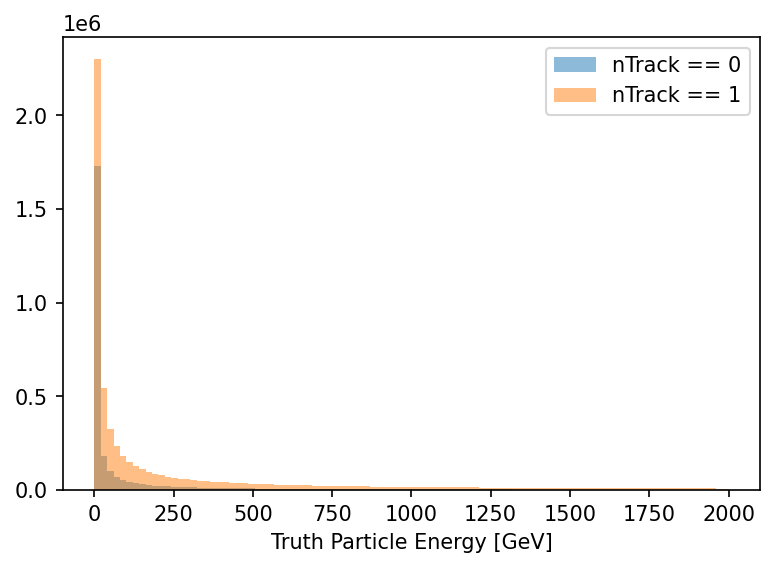

In [110]:
plt.figure(dpi=150)
bins=np.linspace(0.5,2000,100)
plt.hist(df_all[df_all.nTrack == 0].truthPartE, bins=bins, alpha=0.5, label="nTrack == 0");
plt.hist(df_all[df_all.nTrack == 1].truthPartE, bins=bins, alpha=0.5, label="nTrack == 1");
plt.xlabel("Truth Particle Energy [GeV]")
plt.legend()
# plt.ylim(0,100000)

In [79]:
cluster_e = []
for i in tqdm(range(len(df))): 
    event_pass = True
    for cluster in range(len(df.cluster_E.iloc[i])):
        if np.array(df.cluster_E.iloc[i][cluster]) > 0.5: 
            event_pass = False
            continue
    cluster_e.append(event_pass)

100%|██████████| 1996000/1996000 [00:53<00:00, 37511.95it/s]


In [81]:
len(cluster_e)

1996000

In [82]:
np.sum(cluster_e)

717400

In [78]:
np.sum(np.array(cluster_e) > 0.5)/len(cluster_e)

0.8820795248381403

In [86]:
df.nTrack.value_counts()

1     1212558
0      752330
2       13601
3        5431
4        3526
5        1958
6        1375
7        1073
8         802
9         646
10        602
11        510
12        352
13        312
14        233
15        210
16        128
17         99
18         74
19         62
20         39
21         23
22         17
23         13
25          7
24          6
26          4
29          3
28          2
31          2
32          1
27          1
Name: nTrack, dtype: int64

In [85]:
len(df)*.88

1756480.0

In [ ]:
df[(df.truthPartE < 0.5)]